<a href="https://colab.research.google.com/github/bieri2/ATMS597_Project5_GroupB/blob/master/Project5_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
# Read dataset with pre-processed data
features = pd.read_csv('/content/drive/My Drive/Project5_Data/logistic_features_new.csv', index_col=['date_time'], parse_dates=True)

In [0]:
# Define columns to be used to train model
columns = ['air_temperature', 'wind_speed',   
           'low_cloud_level', 'cloud_coverage', 
           'air_temperature', 'dew_point_temperature', 
           'altimeter', 'eastward_wind', 
           'northward_wind', 'time_of_day',
           'wind_direction', 'low_cloud_type', 
           'wx_binary']

# Randomly split data into training and validation sets; 70-30 split
trainX, validX, trainy, validy = train_test_split(features[columns[:-1]], features['wx_binary'], 
                                                  test_size = 0.3, random_state = 42)

In [0]:
# Define decision tree classifier object
dtc    = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 5, 
                                     min_samples_leaf = 4)
# Train model
model  = dtc.fit(trainX, trainy)
# Predict using validation data
prediction = model.predict(validX)

In [0]:
# Get probabilities for each class for both training and validation data
valid_prob = model.predict_proba(validX)
train_prob = model.predict_proba(trainX)

In [0]:
# Define function to calculate climatological probabilities of rain (0) or snow (1)
def get_climo(y, shape):
    """
    Calculates climatological probabilities of rain or snow occurrence, given that
    it is precipitating. In other words, returns probabilities *based on climatology*
    that precipitation is in one class or the other, one class being rain and the other being snow.

    Parameters:
    -y (NumPy array or pandas Series): An array of binary designations corresponding 
    to rain (represented by 0) or snow (represented by 1).
    -shape (tuple): Tuple indicating the shape of the probability array to be returned.

    Returns:
    A NumPy array containing probabilities of rain or snow based on climatology.
    The shape of the array is that corresponding to the input parameter shape.  
    """
    # Calculate probability of snow based on given data
    climo = (np.size((y == 1).values.nonzero()))/float(np.size(y))
    # Create array of zeros to hold probabilities
    prob  = np.zeros((shape))
    # Fill with probability of rain in one class
    prob[:, 0] = 1 - climo
    # Fill with probability of snow in the other 
    prob[:, 1] = climo

    return prob

In [0]:
# Get probabilities based on climatology using training data
train_climo_prob = get_climo(trainy, train_prob.shape)
# Use these probabilities to evaluate the model on validation data
valid_climo_prob = train_climo_prob[:np.size(validy), :]

In [0]:
# Calculate Brier Skill Scores for training and validation sets
bss_train = 1 - (brier_score_loss(trainy, train_prob[:, 1])/brier_score_loss(trainy, train_climo_prob[:, 1]))
bss_valid = 1 - (brier_score_loss(validy, valid_prob[:, 1])/brier_score_loss(validy, valid_climo_prob[:, 1]))

In [0]:
print('Training Brier skill score: '   + str(bss_train))
print('Validation Brier skill score: ' + str(bss_valid))

Training Brier skill score: 0.9857542748680079
Validation Brier skill score: 0.961231466271438


In [0]:
# Calculate ROC curve using scikit-learn
fpr, tpr, thresholds = roc_curve(validy, valid_prob[:, 1])

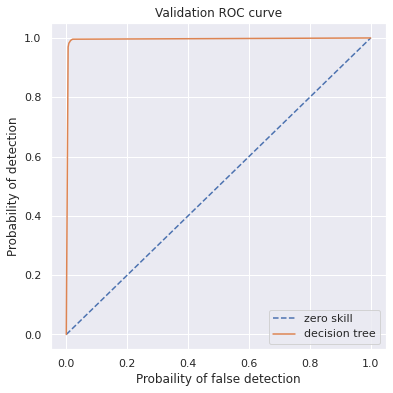

In [0]:
# Plot ROC curve vs. climatology
sns.set()
plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'zero skill')
plt.plot(fpr, tpr, label = 'decision tree')
plt.title('Validation ROC curve')
plt.xlabel('Probaility of false detection')
plt.ylabel('Probability of detection')
plt.legend()
plt.show()

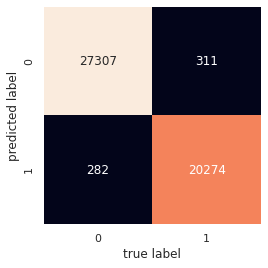

In [0]:
# Plot confusion matrix showing model accuracy
mat = confusion_matrix(validy, prediction)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
plt.xlabel('true label')
plt.ylabel('predicted label');